<a href="https://colab.research.google.com/github/kavyajeetbora/zads/blob/master/development/01_residential_buildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install -q pydeck
!touch __init__.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.6 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import pandas as pd
import pydeck as pdk
import shapely
import duckdb
import os
import time

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

from lxml import etree
import requests

import geemap
import ee

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

In [ ]:
import matplotlib.colors as mp_color
import matplotlib as mpl
import matplotlib.pyplot as plt
import pydeck as pdk
import numpy as np
import base64

In [ ]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [ ]:
%%sql
INSTALL httpfs;
INSTALL spatial;

Empty DataFrame
Columns: [Success]
Index: []

Bounding Box:

In [ ]:
W,S,E,N = 91.7730008646,26.1579902082,91.7868625208,26.1682553455
bbox = shapely.box(W,S,E,N)

## Oveture map latest release

In [ ]:
try:
    url = r'https://docs.overturemaps.org/release/latest/'
    req = requests.get(url)
    html_text = req.text
    tree = etree.HTML(html_text)

    result = tree.xpath('//h1')
    latest_release = result[0].text
    print("latest Overture map release:" ,latest_release)

except Exception as e:
    print("Error", e)

latest Overture map release: 2024-10-23.0


## Get Building Footprints

In [ ]:
%%time

# Check if the file already exists and remove it
if os.path.exists('overture_buildings.geojson'):
    os.remove('overture_buildings.geojson')

buildings_data_url = rf"s3://overturemaps-us-west-2/release/{latest_release}/theme=buildings/type=*/*"

con = duckdb.connect()
con.execute("INSTALL spatial") # Install the spatial extension, which includes GDAL
con.execute("LOAD spatial")  # Load the spatial extension

df = con.sql(
    f'''
    COPY(
        SELECT
            buildings.names.primary as name,
            sources[1].dataset AS primary_source,
            buildings.num_floors,
            buildings.geometry
        FROM read_parquet('{buildings_data_url}', filename=true, hive_partitioning=1) AS buildings
        WHERE buildings.bbox.xmin > {W}
        AND buildings.bbox.xmax < {E}
        AND buildings.bbox.ymin > {S}
        AND buildings.bbox.ymax < {N}
    ) TO 'overture_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
    '''
)
con.close() # Close the connection

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 8.67 s, sys: 664 ms, total: 9.34 s
Wall time: 2min 52s


## Summarize the data

In [ ]:
gdf = gpd.read_file("overture_buildings.geojson")

print(f"Total number of buildings found: {gdf.shape[0]}")
gdf['primary_source'].value_counts()

Total number of buildings found: 3028


primary_source
Google Open Buildings     2230
Microsoft ML Buildings     662
OpenStreetMap              136
Name: count, dtype: int64

In [ ]:
gdf[gdf['num_floors'].notna()]

name primary_source  num_floors  \
905   None  OpenStreetMap        13.0   
916   None  OpenStreetMap        13.0   
1350  None  OpenStreetMap        16.0   
1358  None  OpenStreetMap        16.0   

                                               geometry  
905   POLYGON ((91.78024 26.16278, 91.78023 26.16298...  
916   POLYGON ((91.78023 26.16347, 91.78004 26.16346...  
1350  POLYGON ((91.77852 26.16505, 91.77854 26.16509...  
1358  POLYGON ((91.77892 26.16497, 91.77894 26.16508...

Convert the geodataframe to `ee.FeatureCollection`

In [ ]:
ee_bfs = geemap.gdf_to_ee(gdf)

## Download the building heights data

Using the google open buildings 2.5 Dataset

In [ ]:
bbox_geom = ee.Geometry.BBox(W,S,E,N)

In [ ]:
building_height = ee.ImageCollection("GOOGLE/Research/open-buildings-temporal/v1")\
.filterBounds(bbox_geom)\
.filterDate('2023-01-01', '2023-12-31')\
.first()

info = building_height.getInfo()
band_info = info['bands'][0]
width = band_info['dimensions'][0]
height = band_info['dimensions'][1]
print(f"Width: {width}, Height: {height}")

Width: 1169904, Height: 1533248


In [ ]:
%%time

Map = geemap.Map()
Map.centerObject(ee_bfs,zoom=14)

vis_params = {'min':0, 'max':100}
Map.addLayer(building_height.clip(bbox_geom), vis_params = vis_params)
Map.addLayer(ee_bfs)
Map

CPU times: user 4.21 s, sys: 161 ms, total: 4.37 s
Wall time: 14.2 s


Map(center=[26.16285797932039, 91.77904193939835], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
building = ee_bfs.first()

def extract_height(feature):
    stats = building_height.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=feature.geometry(),
        scale=4
    )

    height = stats.get('building_height')

    return feature.set('height',height)

In [ ]:
bfs = ee_bfs.map(extract_height)

In [ ]:
%%time
gdf2 = geemap.ee_to_gdf(bfs)
gdf2['height'] = gdf2['height'].round().fillna(0).clip(lower=3).astype(int)
gdf2['num_floors'] = gdf2['num_floors'].fillna(value=0).astype(int)
gdf2['name'] = gdf2['name'].fillna(value="Unknown")
gdf2.head()

CPU times: user 5.11 s, sys: 58.6 ms, total: 5.17 s
Wall time: 20.1 s


geometry  height  \
0  POLYGON ((91.77301 26.1582, 91.77309 26.15819,...      10   
1  POLYGON ((91.77304 26.15828, 91.77311 26.15826...      11   
2  POLYGON ((91.77319 26.15824, 91.77345 26.15818...       3   
3  POLYGON ((91.77354 26.15811, 91.77359 26.15809...       3   
4  POLYGON ((91.77325 26.15832, 91.77343 26.15829...       5   

          primary_source     name  num_floors  
0  Google Open Buildings  Unknown           0  
1  Google Open Buildings  Unknown           0  
2  Google Open Buildings  Unknown           0  
3  Google Open Buildings  Unknown           0  
4  Google Open Buildings  Unknown           0

In [ ]:
gdf2[gdf2['num_floors'].notna()]

geometry  height  \
0     POLYGON ((91.77301 26.1582, 91.77309 26.15819,...      10   
1     POLYGON ((91.77304 26.15828, 91.77311 26.15826...      11   
2     POLYGON ((91.77319 26.15824, 91.77345 26.15818...       3   
3     POLYGON ((91.77354 26.15811, 91.77359 26.15809...       3   
4     POLYGON ((91.77325 26.15832, 91.77343 26.15829...       5   
...                                                 ...     ...   
3023  POLYGON ((91.78665 26.16778, 91.7867 26.16778,...       5   
3024  POLYGON ((91.7868 26.16791, 91.78683 26.16791,...       5   
3025  POLYGON ((91.7863 26.16817, 91.7863 26.16812, ...       3   
3026  POLYGON ((91.78642 26.16819, 91.78642 26.16815...       3   
3027  POLYGON ((91.78673 26.16818, 91.78674 26.16812...       3   

              primary_source     name  num_floors  
0      Google Open Buildings  Unknown           0  
1      Google Open Buildings  Unknown           0  
2      Google Open Buildings  Unknown           0  
3      Google Open Buildings  Unknown           0  
4      Google Open Buildings  Unknown           0  
...                      ...      ...         ...  
3023   Google Open Buildings  Unknown           0  
3024   Google Open Buildings  Unknown           0  
3025  Microsoft ML Buildings  Unknown           0  
3026   Google Open Buildings  Unknown           0  
3027   Google Open Buildings  Unknown           0  

[3028 rows x 5 columns]

In [ ]:
gdf2.columns

Index(['geometry', 'height', 'primary_source', 'name', 'num_floors'], dtype='object')

## Visualize the map

Generate colormap:

In [ ]:
def get_color_value(value, cmap, norm):
    # Normalize the value to the range of the colormap
    norm_value = norm(value)

    # Get the color value from the colormap
    color = cmap(norm_value)

    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors


def colormap_dataframe(df, value_col, cmap, norm, max_val=None):

    xdf = df.copy()
    xdf['color'] = xdf[f'{value_col}'].apply(lambda x: get_color_value(x, cmap, norm))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color'], axis=1)

    xdf[value_col] = xdf[value_col].round(1)

    return xdf

def generate_linear_colorscale(cmap_name, vmin, vmax, size):
    # Generate a range of values from vmin to vmax in log scale
    values = np.linspace(vmin, vmax, size)

    # Get the colormap
    cmap = plt.get_cmap(cmap_name)

    # Normalize the values to the range [0, 1]
    norm = plt.Normalize(vmin, vmax)

    # Generate the colorscale
    colors = cmap(norm(values))

    return values, colors

def generate_html_from_fig(image_file):
    # Convert the image to base64 format
    with open(image_file, "rb") as f:
        encoded_image = base64.b64encode(f.read())

    html = "".format(
        encoded_image.decode("utf-8")
    )

    return html

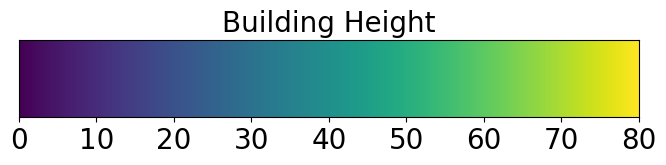

In [ ]:
cmap_name = 'viridis'
vmin=0
vmax=gdf2['height'].max()
size=gdf2.shape[0]
fontsize = 20

values, colors = generate_linear_colorscale(cmap_name, vmin, vmax, size=size)

# Plot the colorscale
plt.figure(figsize=(8, 1))
plt.imshow([colors], aspect='auto', extent=[vmin, vmax, 0, 1])
plt.yticks([])
plt.xticks(fontsize=fontsize)
plt.title(f'Building Height', fontsize=fontsize)
plt.savefig('legend.jpg',bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
legend_html = generate_html_from_fig("legend.jpg")

In [ ]:
norm = mp_color.Normalize(vmin, vmax)
geo_df_final = colormap_dataframe(gdf2, value_col='height', cmap=mpl.colormaps[cmap_name], norm=norm)
geo_df_final.sample(5)

geometry  height  \
762   POLYGON ((91.77712 26.16198, 91.77725 26.16193...       3   
1419  POLYGON ((91.7789 26.16559, 91.77899 26.16558,...       5   
2995  POLYGON ((91.7855 26.16724, 91.78554 26.16723,...       5   
1281  POLYGON ((91.77636 26.16555, 91.7765 26.16553,...      17   
2695  POLYGON ((91.78292 26.16626, 91.78309 26.16624...      12   

              primary_source     name  num_floors   R   G    B    A  
762    Google Open Buildings  Unknown           0  70  14   97  100  
1419           OpenStreetMap  Unknown           0  71  24  106  100  
2995  Microsoft ML Buildings  Unknown           0  71  24  106  100  
1281           OpenStreetMap  Unknown           0  63  71  136  100  
2695   Google Open Buildings  Unknown           0  69  52  127  100

In [ ]:
%%time
gdf2_viz_json=eval(geo_df_final.to_json())

CPU times: user 870 ms, sys: 48 ms, total: 918 ms
Wall time: 928 ms


In [ ]:
tooltip = {
    "html": "🏢 Name: {name}<br>📏 Height: {height} meters<br>🔍 Primary Source: {primary_source}<br>🏢 Number of Floors: {num_floors}",
    "style": {
        "backgroundColor": "#333333",   # Dark background
        "color": "#FFFFFF",             # White text color
        "border": "2px solid #4CAF50",  # Green border color
        "borderRadius": "8px",          # Rounded corners
        "padding": "10px",              # Padding inside the tooltip
        "fontFamily": "Arial, sans-serif",  # Font style
        "fontSize": "14px",             # Font size
        "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.5)"  # Soft shadow effect
    }
}

building_layer = pdk.Layer(
    'GeoJsonLayer',
    data=gdf2_viz_json,
    stoked=True,
    getLineColor=[158, 2, 38,100],
    getLineWidth=10,
    filled=True,
    get_fill_color=['properties.R', 'properties.G', 'properties.B','properties.A'],
    extruded=True,
    get_elevation='properties.height*3',
    pickable=True
)

# Set the viewport location
x,y = bbox.centroid.x, bbox.centroid.y
view_state = pdk.ViewState(latitude=y, longitude=x, zoom=15, bearing=0, pitch=45)

# # Render
r = pdk.Deck(layers=[building_layer], initial_view_state=view_state, tooltip=tooltip)
r.to_html("index.html")

<IPython.core.display.Javascript object>